In [1]:
from IPython.core.display import display, HTML
from IPython.display import Image
display(HTML("<style>.container { width:100% !important; }</style>"))

### Join Refseq Bed12 file with gene symbols, deduplicate to show only one splicing option for each gene

In [2]:
!bedtools intersect \
    -a <(sort -k1,1 -k2,2n tracks_data/m10_refseq.bed) \
    -b <(cat /Users/alynch/miniconda3/envs/torch/lib/python3.8/site-packages/lisa/genomes/mm10.refseq | cut -f 2,4,5,8 | sort -k1,1 -k2,2n | uniq) \
    -f 1 -F 1 -wa -wb | awk '{OFS = "\t"} {print $1,$2,$3,toupper($16),$5,$6,$7,$8,$9,$10,$11,$12}' | awk '!seen[$4]++' > tracks_data/filtered_genes.bed

### Extract reads within an expanded region around a gene

In [2]:
import pickle
import numpy as np
import subprocess
import os

In [3]:
slop_distance=75000
path='/Users/alynch/miniconda3/envs/pygenometracks/bin/'
genome='/Users/alynch/genomes/mm10/mm10.genome'
with open('tracks_data/gois.txt', 'r') as f:
    genes = [x.strip() for x in f]

In [5]:
awk_str = "'{}'".format(
    '\\|'.join(genes)
)

In [6]:
!cat tracks_data/filtered_genes.bed | grep $awk_str | bedtools slop -g /Users/alynch/genomes/mm10/mm10.genome -b $slop_distance | cut -f1-6 > tracks_data/intervals.bed

In [7]:
!bedtools intersect -a tracks_data/GSM4156597_skin.late.anagen.atac.fragments.bed.gz \
    -b tracks_data/intervals.bed \
    -wa > tracks_data/WNT3_reads.bed

In [8]:
!wc -l tracks_data/WNT3_reads.bed

 9263111 tracks_data/WNT3_reads.bed


## Compute gene-gene correlation links

In [9]:
!awk '{OFS = "\t"} {print $1,$2-50000,$3+50000,$4, ($6 == "+") ? $2 : $3}' tracks_data/filtered_genes.bed > tracks_data/genes_with_promoter.bed

In [10]:
!bedtools intersect -a tracks_data/genes_with_promoter.bed \
    -b tracks_data/genes_with_promoter.bed -wa -wb | \
    awk '$4 != $9' | awk '{OFS="\t"}{print $1,$5,$4,$6,$10,$9}' > tracks_data/gene_gene_links.bed

In [4]:
expr = np.load('./2021-03-19_RNA_encoded_expr.npy')

In [5]:
with open('model_genes.txt','r') as f:
    modeled_genes = np.array([x.strip() for x in f])

In [6]:
gene_gene_corr = np.corrcoef(expr.T)
gene_gene_corr.shape

(5104, 5104)

In [7]:
gene_idx_dict = dict(zip(modeled_genes, np.arange(len(modeled_genes))))

In [8]:
gene_pairs = []
gene_info = []
with open('tracks_data/gene_gene_links.bed', 'r') as f:
    for line in f:
        fields = line.strip().split('\t')
        try:
            gene_pairs.append((gene_idx_dict[fields[2]], gene_idx_dict[fields[-1]]))
            gene_info.append(fields)
        except KeyError:
            pass
        
gene_pairs = np.array(gene_pairs)

In [9]:
with open('tracks_data/links.arc', 'w') as f:
    for (chr1, pos1, gene1, chr2, pos2, gene2), corr in zip(gene_info, gene_gene_corr[gene_pairs[:,0], gene_pairs[:,1]]):
        print(chr1, pos1, int(pos1)+1, chr2, pos2, int(pos2)+1, corr, gene1, gene2, sep = '\t', file = f)

### Compute RP Function Overlay

In [14]:
with open('tracks_data/intervals.bed', 'r') as f:
    intervals = [x.strip().split('\t') for x in f]

In [18]:
for chrom, start, end, gene, _, strand in intervals:
    
    start, end = int(start), int(end)
    gene = gene.upper()
    
    try:
        with open('./rp_estimation_models/vi/{}_trace.pkl'.format(gene), 'rb') as f:
            trace = pickle.load(f)
        
        distance_up, distance_down = 1e3 * np.exp(np.array(trace['logdistance']).mean(0))
        
        locs = np.arange(start, end)
        if strand == '+':
            promoter = start + slop_distance
            decay = np.where(locs < promoter, distance_up, distance_down)
        else:
            promoter = end - slop_distance
            decay = np.where(locs > promoter, distance_up, distance_down)
        
        bg_file = 'tracks_data/{}_RP_func.bedgraph'.format(gene)
        with open(bg_file, 'w') as f:
            distance = np.abs(locs - promoter)
            weights = np.where(distance < 1500, 1, np.power(0.5, (distance - 1500)/decay))
            
            for loc, weight in zip(locs, weights):
                print(chrom, loc, loc+1, weight, sep = '\t', file = f)
        
        bigwig_cmd = [os.path.join(path, 'bedGraphToBigWig'), bg_file, genome, 'tracks_data/{}_RP_func.bw'.format(gene)]
        print(' '.join(bigwig_cmd))
        subprocess.run(bigwig_cmd)
        
    except FileNotFoundError:
        print('No model for {}'.format(gene))

/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/PTP4A1_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/PTP4A1_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/RNF149_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/RNF149_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/STK17B_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/STK17B_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/MREG_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/MREG_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/PID1_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/PID1_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/FARP2_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/F

/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/HSPBAP1_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/HSPBAP1_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/EVA1C_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/EVA1C_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/RUNX1_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/RUNX1_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/ARID1B_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/ARID1B_RP_func.bw
No model for TREML4
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/OSBPL1A_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/OSBPL1A_RP_func.bw
No model for RELL2
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/RAB27B_RP_func.bedgraph /Use

/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/OSBPL3_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/OSBPL3_RP_func.bw
No model for ITPRID1
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/NUP210_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/NUP210_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/TMF1_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/TMF1_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/FRMD4B_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/FRMD4B_RP_func.bw
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/AEBP2_RP_func.bedgraph /Users/alynch/genomes/mm10/mm10.genome tracks_data/AEBP2_RP_func.bw
No model for CAPRIN2
/Users/alynch/miniconda3/envs/pygenometracks/bin/bedGraphToBigWig tracks_data/PSMD8_RP_func.bedgraph /Users/a

### Join with pseudotime clusters, then aggregate

In [19]:
!join -1 1 -2 2 <(sort -k1,1 tracks_data/pseudotime.tsv) <(sort -k2,2 tracks_data/GSM4156597_skin_celltype.txt) | awk '{OFS = "\t"} {print $6,$1,$2,$3,$4,$5,$7}' > tracks_data/barcode_data.tsv

In [20]:
!join -1 4 -2 1 <(cat tracks_data/WNT3_reads.bed | tr "," "." | sort -k4,4) \
    <(sort -k1,1 tracks_data/barcode_data.tsv) | awk '{OFS="\t"} $6 >= 0 || $8 > 0 {print $2,$3,$4,$6,$8,$10}' | \
    sort -k1,1 -k2,2n > tracks_data/pseudotime_labeled_reads.bed

sort: Broken pipe


### Convert reads to BigWig

TAC cells

In [21]:
!awk '$4 > 0 && $4 <= 3' tracks_data/pseudotime_labeled_reads.bed | \
    bedtools genomecov -i - -g $genome -bg -scale $((100000/$(awk '$3 > 0 && $3 <= 3' tracks_data/barcode_data.tsv | wc -l))) \
    | sort -k1,1 -k2,2n > tracks_data/TAC.bedgaph

!$path/bedGraphToBigWig tracks_data/TAC.bedgaph $genome tracks_data/TAC.bw

Branch Cells

In [22]:
!awk '$4 > 3 && $4 <= 7' tracks_data/pseudotime_labeled_reads.bed | \
    bedtools genomecov -i - -g $genome -bg -scale $((100000/$(awk '$3 > 3 && $3 <= 7' tracks_data/barcode_data.tsv | wc -l))) \
    | sort -k1,1 -k2,2n > tracks_data/Branch.bedgaph

!$path/bedGraphToBigWig tracks_data/Branch.bedgaph $genome tracks_data/Branch.bw

Cortex Cells

In [23]:
!awk '$4 > 7' tracks_data/pseudotime_labeled_reads.bed | \
    bedtools genomecov -i - -g $genome -bg -scale $((100000/$(awk '$3 > 7' tracks_data/barcode_data.tsv | wc -l))) \
    | sort -k1,1 -k2,2n > tracks_data/Cortex.bedgaph

!$path/bedGraphToBigWig tracks_data/Cortex.bedgaph $genome tracks_data/Cortex.bw

Medulla Cells

In [24]:
!awk '$5 > 5' tracks_data/pseudotime_labeled_reads.bed | \
    bedtools genomecov -i - -g $genome -bg -scale $((100000/$(awk '$5 > 5' tracks_data/barcode_data.tsv | wc -l))) \
    | sort -k1,1 -k2,2n > tracks_data/Medulla.bedgaph

!$path/bedGraphToBigWig tracks_data/Medulla.bedgaph $genome tracks_data/Medulla.bw

### Make tracks config

In [215]:
!$path/make_tracks_file --trackFiles tracks_data/filtered_genes.bed tracks_data/TAC.bw tracks_data/Branch.bw tracks_data/Cortex.bw -o tracks_data/_tac_tracks.ini

Adding bed file: tracks_data/filtered_genes.bed
Adding bigwig file: tracks_data/TAC.bw
Adding bigwig file: tracks_data/Branch.bw
Adding bigwig file: tracks_data/Cortex.bw


### Make Image

In [25]:
!rm -rf tracks_data/*.bedgraph

In [12]:
#run_genes = ['MREG','TOM1','IGSF3','RUNX1','RFFL','PDZD8','RAB27B','WNT3']
run_genes = []

In [15]:
function_block = '''

[RP Function]
file = tracks_data/{gene}_RP_func.bw
color = #666666
{title}
height = 2.5
min_value = 0
max_value = 1.1
number_of_bins = 700
nans_to_zeros = true
summary_method = mean
type = line
show_data_range = false
file_type = bigwig
overlay_previous = {prev}

'''

with open('tracks_data/tac_tracks.ini', 'r') as f:
    track_template = f.readlines()

for i in range(len(track_template)):
    if track_template[i] == '#RPFUNCTIONS\n':
        break

j = 0
for interval in intervals:
    gene_name = interval[3].upper()
    if (gene_name in run_genes or len(run_genes) == 0) and os.path.isfile('tracks_data/{}_RP_func.bw'.format(gene_name)):
        track_template.insert(i, function_block.format(gene = gene_name, prev = 'share-y' if j > 0 else 'no', title = 'title = RP Function' if j==0 else ''))
        i+=1
        j+=1

with open('tracks_data/track_config.ini', 'w') as f:
    print(''.join(track_template), file = f)

In [16]:
!rm -rf tracks_data/images/*.png

In [28]:
!cat tracks_data/links.arc | sort -k7,7n | tail

chr8	11312804	11312805	chr8	11312826	11312827	0.49099482084462676	COL4A2	COL4A1
chr8	11312826	11312827	chr8	11312804	11312805	0.49099482084462676	COL4A1	COL4A2
chr1	45311537	45311538	chr1	45503282	45503283	0.6169512233839741	COL3A1	COL5A2
chr1	45503282	45503283	chr1	45311537	45311538	0.6169512233839741	COL5A2	COL3A1
chr2	32363009	32363010	chr2	32424066	32424067	4.777100712435179e-05	CIZ1	SLC25A25
chr2	32424066	32424067	chr2	32363009	32363010	4.777100712435179e-05	SLC25A25	CIZ1
chr15	10485937	10485938	chr15	10713540	10713541	5.614316463844107e-05	BRIX1	RAI14
chr15	10713540	10713541	chr15	10485937	10485938	5.614316463844107e-05	RAI14	BRIX1
chr18	61177049	61177050	chr18	61211596	61211597	6.707126713333921e-05	HMGXB3	SLC26A2
chr18	61211596	61211597	chr18	61177049	61177050	6.707126713333921e-05	SLC26A2	HMGXB3


In [29]:
!join -1 4 -2 8 <(sort -k4,4 tracks_data/intervals.bed) <(sort -k8,8 tracks_data/links.arc) | sort -k13,13n

KRT35 chr11 100017191 100171224 0 - chr11 100096224 100096225 chr11 100135949 100135950 -0.05271262535527868 KRT15
RNF145 chr11 44444376 44629977 0 + chr11 44519376 44519377 chr11 44618099 44618100 -0.017495412817953415 EBF1
THSD4 chr9 59891930 60216220 0 - chr9 60141220 60141221 chr9 59751173 59751174 -0.015658297575468095 MYO9A
ARHGEF10L chr4 140439484 140723756 0 - chr4 140648756 140648757 chr4 140701472 140701473 -0.010777482405067151 RCC2
FRRS1 chr3 116784566 116978750 0 + chr3 116859566 116859567 chr3 116968952 116968953 -0.010585285207027109 PALMD
OSBPL3 chr6 50218326 50457837 0 - chr6 50382837 50382838 chr6 50110240 50110241 -0.008184964259870265 MPP6
SIRT1 chr10 63244004 63414035 0 - chr10 63339035 63339036 chr10 63430097 63430098 -0.008165391981594952 CTNNA3
TOM1L2 chr11 60151713 60427905 0 - chr11 60352905 60352906 chr11 60105012 60105013 -0.008147598571704901 RAI1
DENND4A chr9 64736010 64994667 0 + chr9 64811010 64811011 chr9 64737756 64737757 -0.008028301123784668 RAB11A
T

In [18]:
!$path/pyGenomeTracks --tracks tracks_data/track_config.ini --BED tracks_data/intervals.bed -out tracks_data/images/.
#!$path/pyGenomeTracks --tracks tracks_data/tac_tracks.ini --region chr4:4685960-4885960 -out tracks_data/images/test.


INFO:pygenometracks.tracksClass:initialize 1. [x-axis]
INFO:pygenometracks.tracksClass:initialize 2. [spacer]
INFO:pygenometracks.tracksClass:initialize 3. [links]
100%|████████████████████████████████████| 2820/2820 [00:00<00:00, 55263.50it/s]
INFO:pygenometracks.tracksClass:initialize 4. [filtered_genes]
100%|██████████████████████████████████████| 899/899 [00:00<00:00, 19320.07it/s]
INFO:pygenometracks.tracksClass:initialize 5. [RP Function]
INFO:pygenometracks.tracksClass:initialize 6. [RP Function]
INFO:pygenometracks.tracksClass:initialize 7. [RP Function]
INFO:pygenometracks.tracksClass:initialize 8. [RP Function]
INFO:pygenometracks.tracksClass:initialize 9. [RP Function]
INFO:pygenometracks.tracksClass:initialize 10. [RP Function]
INFO:pygenometracks.tracksClass:initialize 11. [RP Function]
INFO:pygenometracks.tracksClass:initialize 12. [RP Function]
INFO:pygenometracks.tracksClass:initialize 13. [RP Function]
INFO:pygenometracks.tracksClass:initialize 14. [RP Function]
INFO:

*Warning, invalid strand valuefound -2.6487585082118503 for line #chr9	59946657	59946957	62041	5.701668351871324	-2.6487585082118503
:
346
 Setting strand to '.'
*Warning, invalid strand valuefound -1.1092399086982225 for line #chr15	99452696	99452996	62067	3.575431095863143	-1.1092399086982225
:
347
 Setting strand to '.'
*Warning, invalid strand valuefound 1.7320791036557146 for line #chr7	79207162	79207462	62129	3.5161673080517657	1.7320791036557146
:
348
 Setting strand to '.'
*Warning, invalid strand valuefound -1.2779190134155067 for line #chr12	91848545	91848845	62280	3.0437739422896857	-1.2779190134155067
:
349
 Setting strand to '.'
*Warning, invalid strand valuefound -1.589868005039803 for line #chr6	148960016	148960316	63346	5.614039196304194	-1.589868005039803
:
350
 Setting strand to '.'
*Warning, invalid strand valuefound -1.689405037385822 for line #chr9	15207819	15208119	63682	6.353902287633862	-1.689405037385822
:
351
 Setting strand to '.'
*Warning, invalid strand val

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:1 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
INFO:pygenometracks.tracksClass:plotting 7. [RP Function]
INFO:pygenometracks.tracksClass:plotting 8. [RP Function]
INFO:pygenometracks.tracksClass:plotting 9. [RP Function]
INFO:pygenometracks.tracksClass:plotting 10. [RP Function]
INFO:pygenometracks.tracksClass:plotting 11. [RP Function]
INFO:pygenometracks.tracksClass:plotting 12. [RP Function]
INFO:pygenometracks.tracksClass:plotting 13. [RP Function]
INFO:pygenometracks.tracksClass:plotting 14. [RP Function]
INFO:pygenometracks.tracksClass:plotting 15. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. Th

INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 102. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty t

INFO:pygenometracks.tracksClass:plotting 117. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 118. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 121. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty t

Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 70. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 71. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 72. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 73. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 74. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 75. [RP Function

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 117. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 118. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty t

INFO:pygenometracks.tracksClass:plotting 94. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 95. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 15. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 16. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 17. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 18. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 19. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 20. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_FARP2_chr1-93437103-93696976.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:3 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
INFO:pygenometracks.tracksClass:plotting 7. [RP Function]
INFO:pygenometracks.tracksClass:plotting 8. [RP Function]
INFO

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_NCKAP5_chr1-125838635-126567927.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:0 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
INFO:pygenometracks.tracksClass:plotting 7. [RP Function]
INFO:pygenometracks.tracksClass:plotting 8. [RP Function]
IN

Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 102. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Fu

INFO:pygenometracks.tracksClass:plotting 85. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 86. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 87. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 88. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 89. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 90. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_TMEM63A_chr1-180867517-181050104.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:0 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
INFO:pyg

INFO:pygenometracks.tracksClass:plotting 94. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 95. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 15. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 16. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 17. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 18. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 19. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 20. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 74. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr1 nor 1 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_MAP7_chr10-20073919-20356590.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:2 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
Neither chr

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_SLC16A10_chr10-39958534-40217254.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:0 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
Neither

INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_VPS26A_chr10-62379842-62561598

Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 102. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 19. [RP Function]
INFO:pygenometracks.tracksClass:plotting 20. [RP Function]
INFO:pygenometracks.tracksClass:plotting 21. [RP Function]
INFO:pygenometracks.tracksClass:plotting 22. [RP Function]
INFO:pygenometracks.tracksClass:plotting 23. [RP Function]
INFO:pygenometracks.tracksClass:plotting 24. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 25. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 26. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 27. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksCla

INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 100. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an

INFO:pygenometracks.tracksClass:plotting 17. [RP Function]
INFO:pygenometracks.tracksClass:plotting 18. [RP Function]
INFO:pygenometracks.tracksClass:plotting 19. [RP Function]
INFO:pygenometracks.tracksClass:plotting 20. [RP Function]
INFO:pygenometracks.tracksClass:plotting 21. [RP Function]
INFO:pygenometracks.tracksClass:plotting 22. [RP Function]
INFO:pygenometracks.tracksClass:plotting 23. [RP Function]
INFO:pygenometracks.tracksClass:plotting 24. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 25. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 26. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 27. [RP Function]
Neither chr10 nor 10 

Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_FGD6_chr10-93961000-94220339.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:3 were links plotted
INFO:pygenometracks.

Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 62. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 63. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 64. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 65. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 66. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 67. 

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_OSBPL8_chr10-111089801-111372247.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:0 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
Neither

INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detec

INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an e

INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [M

Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 121. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
Neither chr10 nor 10 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 85. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 86. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 87. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_MTMR3_chr11-4405867-4669815.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tr

Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 91. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 92. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 94. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 95. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 96. 

INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_SPRED2_chr11-19849441-20097597.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:1 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:py

INFO:pygenometracks.tracksClass:plotting 118. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 121. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generat

Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 28. [RP Function]
INFO:pygenometracks.tracksClass:plotting 29. [RP Function]
INFO:pygenometracks.tracksClass:plotting 30. [RP Function]
INFO:pygenometracks.tracksClass:plotting 31. [RP Function]
INFO:pygenometracks.tracksClass:plotting 32. [RP Function]
INFO:pygenometracks.tracksClass:plotting 33. [RP Function]
INFO:pygenometracks.tracksClass:plotting 34. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 35. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 36. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 37. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This wi

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_CYFIP2_chr11-46118848-46387358.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks

Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 100. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 102. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 1

INFO:pygenometracks.tracksClass:plotting 30. [RP Function]
INFO:pygenometracks.tracksClass:plotting 31. [RP Function]
INFO:pygenometracks.tracksClass:plotting 32. [RP Function]
INFO:pygenometracks.tracksClass:plotting 33. [RP Function]
INFO:pygenometracks.tracksClass:plotting 34. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 35. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 36. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 37. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 38. [RP Function]
Neither chr11 nor 11 exists a

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_PIMREG_chr11-71967501-72122370.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 85. 

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_SERPINF2_chr11-75356735-75514501.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsiz

INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 102. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generat

INFO:pygenometracks.tracksClass:plotting 26. [RP Function]
INFO:pygenometracks.tracksClass:plotting 27. [RP Function]
INFO:pygenometracks.tracksClass:plotting 28. [RP Function]
INFO:pygenometracks.tracksClass:plotting 29. [RP Function]
INFO:pygenometracks.tracksClass:plotting 30. [RP Function]
INFO:pygenometracks.tracksClass:plotting 31. [RP Function]
INFO:pygenometracks.tracksClass:plotting 32. [RP Function]
INFO:pygenometracks.tracksClass:plotting 33. [RP Function]
INFO:pygenometracks.tracksClass:plotting 34. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 35. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 36. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.t

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_ACACA_chr11-84120437-84476651.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.

INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_OSBPL7_chr11-96975819-97143904.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 117. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 118. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 121. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generat

INFO:pygenometracks.tracksClass:plotting 31. [RP Function]
INFO:pygenometracks.tracksClass:plotting 32. [RP Function]
INFO:pygenometracks.tracksClass:plotting 33. [RP Function]
INFO:pygenometracks.tracksClass:plotting 34. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 35. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 36. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 37. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 38. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will gener

Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 95. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 100.

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:0 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 7. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 8. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 9. [

Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [B

Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 61. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 62. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 63. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 64. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 65. 

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_HID1_chr11-115272708-115442719.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chr11 nor 11 exists as a chromosome name inside the bigwig file. This will generat

INFO:pygenometracks.tracksClass:plotting 35. [RP Function]
INFO:pygenometracks.tracksClass:plotting 36. [RP Function]
INFO:pygenometracks.tracksClass:plotting 37. [RP Function]
INFO:pygenometracks.tracksClass:plotting 38. [RP Function]
INFO:pygenometracks.tracksClass:plotting 39. [RP Function]
INFO:pygenometracks.tracksClass:plotting 40. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 41. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 42. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 43. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksCla

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_STON2_chr12-91558008-91861436.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.

INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 94. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 95. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an e

INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:1 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 7. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 8. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 9. [RP Function]
Neither chr12 nor 12 exists as a chromos

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_PPP1R13B_chr12-111753457-111983055.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometr

Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 85. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 86. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 87. 

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_INF2_chr12-112513783-112690557.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=

INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_JAG2_chr12-112833589-113004495.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

INFO:pygenometracks.tracksClass:plotting 40. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 41. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 42. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 43. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 44. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 45. [RP Function]
Neither chr12 nor 12 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_NID1_chr13-13362601-13587275.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.t

INFO:pygenometracks.tracksClass:plotting 41. [RP Function]
INFO:pygenometracks.tracksClass:plotting 42. [RP Function]
INFO:pygenometracks.tracksClass:plotting 43. [RP Function]
INFO:pygenometracks.tracksClass:plotting 44. [RP Function]
INFO:pygenometracks.tracksClass:plotting 45. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 46. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr13 nor 13 exists a

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generat

INFO:pygenometracks.tracksClass:plotting 42. [RP Function]
INFO:pygenometracks.tracksClass:plotting 43. [RP Function]
INFO:pygenometracks.tracksClass:plotting 44. [RP Function]
INFO:pygenometracks.tracksClass:plotting 45. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 46. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will gener

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_PRELID1_chr13-55247054-55400272.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too m

Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 73. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 74. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. 


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_AGTPBP1_chr13-59374534-59631922.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 43. [RP Function]
INFO:pygenometracks.tracksClass:plotting 44. [RP Function]
INFO:pygenometracks.tracksClass:plotting 45. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 46. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plott

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_HMGCR_chr13-96573961-96745936.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

INFO:pygenometracks.tracksClass:plotting 43. [RP Function]
INFO:pygenometracks.tracksClass:plotting 44. [RP Function]
INFO:pygenometracks.tracksClass:plotting 45. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 46. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plott

INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 100. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an

Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 7. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 8. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 9. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 10. [RP Function]
Neither chr13 nor 13 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 11. [RP 

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_GPRIN2_chr14-34119440-34276633.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an e


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_PSME1_chr14-55503493-55656527.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_TINF2_chr14-55604079-55756817.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_DACH1_chr14-97711845-98244765.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-pack

INFO:pygenometracks.tracksClass:plotting 46. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
Neither chr14 nor 14 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_GTPBP1_chr15-79615895-79796479.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

INFO:pygenometracks.tracksClass:plotting 46. [RP Function]
INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will gener

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_CERK_chr15-86064100-86261141.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 41. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 42. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 43. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 44. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 45. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 46. 

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_NELL2_chr15-95144439-95603252.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.

Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting

Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 37. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 38. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 39. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 40. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 41. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 42. 

INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_KRT75_chr15-101488342-10164890

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
Neither chr15 nor 15 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_ST6GAL1_chr16-23149739-23435350.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometrack

INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksCla

Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr16 nor 16 exists a

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_OSBPL11_chr16-33110070-33318312.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometrack

Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksCla


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_HSPBAP1_chr16-35695385-35903462.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plott

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_EVA1C_chr16-90751718-90980109.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.

INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksCla

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 117. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 118. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generat

INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
Neither chr16 nor 16 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_ARID1B_chr17-4920073-5422656.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.t

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 61. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_TREML4_chr17-48189294-48350358.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

INFO:pygenometracks.tracksClass:plotting 40. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 41. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 42. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 43. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 44. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 45. [RP Function]
Neither chr17 nor 17 exists as a chromosome name inside the bigwig file. This will generate an e


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_OSBPL1A_chr18-12680311-12894907.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 61. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 62. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 63. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plott

INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 121. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generat

Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 100. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 101

INFO:pygenometracks.tracksClass:plotting 21. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 22. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 23. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 24. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 25. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 26. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an e

Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 91. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 92. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 94. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 95. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 96. 

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_SMAD7_chr18-75292364-75470934.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=s

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 61. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 62. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 63. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 64. [RP Function]
Neither chr18 nor 18 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_OSBP_chr19-11890843-12069114.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
INFO:pygenometracks.tracksClass:plotting 61. [RP Function]
INFO:pygenometracks.tracksClass:plotting 62. [RP Function]
INFO:pygenometracks.tracksClass:plotting 63. [RP Function]
INFO:pygenometracks.tracksClass:plotting 64. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 65. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 66. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 67. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
Neither chr19 nor 19 exists a

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_TLE4_chr19-14373071-14672213.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.t

INFO:pygenometracks.tracksClass:plotting 61. [RP Function]
INFO:pygenometracks.tracksClass:plotting 62. [RP Function]
INFO:pygenometracks.tracksClass:plotting 63. [RP Function]
INFO:pygenometracks.tracksClass:plotting 64. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 65. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 66. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 67. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will gener

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_PSAT1_chr19-15830122-15999622.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 74. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. 

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_DOCK8_chr19-24924528-25277432.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.

INFO:pygenometracks.tracksClass:plotting 62. [RP Function]
INFO:pygenometracks.tracksClass:plotting 63. [RP Function]
INFO:pygenometracks.tracksClass:plotting 64. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 65. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 66. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 67. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plott

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_PDZD8_chr19-59221083-59420780.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

INFO:pygenometracks.tracksClass:plotting 63. [RP Function]
INFO:pygenometracks.tracksClass:plotting 64. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 65. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 66. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 67. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 69. [RP Function]
Neither chr19 nor 19 exists as a chro

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_RAB11FIP2_chr19-59827883-60018364.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too

INFO:pygenometracks.tracksClass:plotting 43. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 44. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 45. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 46. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr19 nor 19 exists as a chromosome name inside the bigwig file. This will generate an e

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_YME1L1_chr2-23081504-23274260.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

INFO:pygenometracks.tracksClass:plotting 65. [RP Function]
INFO:pygenometracks.tracksClass:plotting 66. [RP Function]
INFO:pygenometracks.tracksClass:plotting 67. [RP Function]
INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
INFO:pygenometracks.tracksClass:plotting 69. [RP Function]
INFO:pygenometracks.tracksClass:plotting 70. [RP Function]
INFO:pygenometracks.tracksClass:plotting 71. [RP Function]
INFO:pygenometracks.tracksClass:plotting 72. [RP Function]
INFO:pygenometracks.tracksClass:plotting 73. [RP Function]
INFO:pygenometracks.tracksClass:plotting 74. [RP Function]
INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_MVB12B_chr2-33654955-33962946.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:0 were links plotted
INFO:pygenometr

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 61. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 62. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_HSPA5_chr2-34697089-34851529.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 55. [RP Function

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_DCAF17_chr2-70980743-71158457.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
INFO:pygenometracks.tracksClass:plotting 69. [RP Function]
INFO:pygenometracks.tracksClass:plotting 70. [RP Function]
INFO:pygenometracks.tracksClass:plotting 71. [RP Function]
INFO:pygenometracks.tracksClass:plotting 72. [RP Function]
INFO:pygenometracks.tracksClass:plotting 73. [RP Function]
INFO:pygenometracks.tracksClass:plotting 74. [RP Function]
INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksC

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_PDK1_chr2-71798223-71978858.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much 

INFO:pygenometracks.tracksClass:plotting 69. [RP Function]
INFO:pygenometracks.tracksClass:plotting 70. [RP Function]
INFO:pygenometracks.tracksClass:plotting 71. [RP Function]
INFO:pygenometracks.tracksClass:plotting 72. [RP Function]
INFO:pygenometracks.tracksClass:plotting 73. [RP Function]
INFO:pygenometracks.tracksClass:plotting 74. [RP Function]
INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr2 nor 2 exists a

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_OSBPL6_chr2-76331507-76675647.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.

INFO:pygenometracks.tracksClass:plotting 92. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 94. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 95. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:0 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 7. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 8. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 9. [RP Function]
Neither chr2 nor 2 exists as a chromosome name i

INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
Neither chr2 nor 2 exists as a chromosome name 

INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_PRR5L_chr2-101639284-101872707.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tr

INFO:pygenometracks.tracksClass:plotting 70. [RP Function]
INFO:pygenometracks.tracksClass:plotting 71. [RP Function]
INFO:pygenometracks.tracksClass:plotting 72. [RP Function]
INFO:pygenometracks.tracksClass:plotting 73. [RP Function]
INFO:pygenometracks.tracksClass:plotting 74. [RP Function]
INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will gener

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_MGME1_chr2-144195903-144356227.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_RIN2_chr2-145711115-145962616.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_ID1_chr2-152661250-152812410.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 115. [RP Fu

INFO:pygenometracks.tracksClass:plotting 20. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 21. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 22. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 23. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 24. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 25. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 73. [RP Function]
INFO:pygenometracks.tracksClass:plotting 74. [RP Function]
INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an emp

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_DLGAP4_chr2-156538696-156839363.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometrack

INFO:pygenometracks.tracksClass:plotting 44. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 45. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 46. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_ELMO2_chr2-165213030-165391351.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
Neither chr2 nor 2 exists as a chromosome name 

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_PMEPA1_chr2-173149464-173351533.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometrack

Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 52. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 53. [RP Function

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_LIME1_chr2-181306234-181458628.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
Neither chr2 nor 2 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_ZFP704_chr3-9352009-9685085.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tr

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 85. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 86. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 87. [RP Function]
Neither chr3 nor 3 exists a

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_SKIL_chr3-31020057-31197923.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=sel

Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 85. [RP Function]
Neither chr3 nor 3 exists a

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_IGSF3_chr3-101302124-101538060.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 85. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 86. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 87. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plott

INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_CEPT1_chr3-106427259-106622802.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 85. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 86. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 87. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 88. [RP Function]
Neither chr3 nor 3 exists as a chromo

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_SORT1_chr3-108209063-108436519.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:2 were links plotted
INFO:pygenomet

INFO:pygenometracks.tracksClass:plotting 65. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 66. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 67. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 69. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 70. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_VAV3_chr3-109265682-109760694.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.

Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function

Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 111. [RP Fu

INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 85. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 86. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 87. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 88. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 89. [R

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_TTLL7_chr3-146777366-147015256.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks

Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 61. [RP Function]
Neither chr3 nor 3 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 62. [RP Function

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_AKIRIN2_chr4-34475614-34641908.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are r

INFO:pygenometracks.tracksClass:plotting 85. [RP Function]
INFO:pygenometracks.tracksClass:plotting 86. [RP Function]
INFO:pygenometracks.tracksClass:plotting 87. [RP Function]
INFO:pygenometracks.tracksClass:plotting 88. [RP Function]
INFO:pygenometracks.tracksClass:plotting 89. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 90. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 91. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 92. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
Neither chr4 nor 4 exists as a chromo

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_FRRS1L_chr4-56885135-57065391.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=s

INFO:pygenometracks.tracksClass:plotting 87. [RP Function]
INFO:pygenometracks.tracksClass:plotting 88. [RP Function]
INFO:pygenometracks.tracksClass:plotting 89. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 90. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 91. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 92. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 94. [R

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_ADAMTSL1_chr4-85978914-86503382.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:0 were links plotted
INFO:pygenome

INFO:pygenometracks.tracksClass:plotting 86. [RP Function]
INFO:pygenometracks.tracksClass:plotting 87. [RP Function]
INFO:pygenometracks.tracksClass:plotting 88. [RP Function]
INFO:pygenometracks.tracksClass:plotting 89. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 90. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 91. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 92. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an emp

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_OSBPL9_chr4-108986144-109193036.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometrack

INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
INFO:pygenometracks.tracksClass:plotting 85. [RP Function]
INFO:pygenometracks.tracksClass:plotting 86. [RP Function]
INFO:pygenometracks.tracksClass:plotting 87. [RP Function]
INFO:pygenometracks.tracksClass:plotting 88. [RP Function]
INFO:pygenometracks.tracksClass:plotting 89. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plott

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_ARHGEF10L_chr4-140439484-140723756.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometr

INFO:pygenometracks.tracksClass:plotting 64. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 65. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 66. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 67. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 69. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_VPS13D_chr4-144897621-145265666.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometrack

INFO:pygenometracks.tracksClass:plotting 89. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 90. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 91. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 92. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 94. [RP Function]
Neither chr4 nor 4 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_CROT_chr5-8891047-9072146.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.

Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 69. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 70. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 71. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 72. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 73. [RP Function

INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_MAPRE3_chr5-30739640-30941106.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:0 were links plotted
INFO:pygenometr

INFO:pygenometracks.tracksClass:plotting 91. [RP Function]
INFO:pygenometracks.tracksClass:plotting 92. [RP Function]
INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
INFO:pygenometracks.tracksClass:plotting 94. [RP Function]
INFO:pygenometracks.tracksClass:plotting 95. [RP Function]
INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plott

Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 7. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 8. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 9. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 10. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 11. [RP Function]
Ne

INFO:pygenometracks.tracksClass:plotting 74. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 75. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 76. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_LRRC8C_chr5-105444470-105683954.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometrack

INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
INFO:pygenometracks.tracksClass:plotting 94. [RP Function]
INFO:pygenometracks.tracksClass:plotting 95. [RP Function]
INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 100. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an em

Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 89. [RP Function]
INFO:pygenometracks.tracksClass:plotting 90. [RP Function]
INFO:pygenometracks.tracksClass:plotting 91. [RP Function]
INFO:pygenometracks.tracksClass:plotting 92. [RP Function]
INFO:pygenometracks.tracksClass:plotting 93. [RP Function]
INFO:pygenometracks.tracksClass:plotting 94. [RP Function]
INFO:pygenometracks.tracksClass:plotting 95. [RP Function]
INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will gener

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [links]
DEBUG:pygenometracks.tracks.GenomeTrack:0 were links plotted
INFO:pygenometracks.tracksClass:plotting 4. [filtered_genes]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 5. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 6. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 7. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 8. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 9. [RP Funct

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 61. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 62. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 63. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty t

INFO:pygenometracks.tracksClass:plotting 96. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 100. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
Neither chr5 nor 5 exists as a chromosome name inside the bigwig file. This will generate an empty track

INFO:pygenometracks.tracksClass:plotting 46. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 97. [RP Function]
INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
INFO:pygenometracks.tracksClass:plotting 100. [RP Function]
INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
INFO:pygenometracks.tracksClass:plotting 102. [RP Function]
INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks

INFO:pygenometracks.tracksClass:plotting 34. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 35. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 36. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 37. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 38. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 39. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 98. [RP Function]
INFO:pygenometracks.tracksClass:plotting 99. [RP Function]
INFO:pygenometracks.tracksClass:plotting 100. [RP Function]
INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
INFO:pygenometracks.tracksClass:plotting 102. [RP Function]
INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr6 nor 6

Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 83. [RP Function

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_GIMAP7_chr6-48643620-48799636.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 49. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 50. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 51. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 52. [RP Function

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_GPNMB_chr6-48961517-49133182.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

INFO:pygenometracks.tracksClass:plotting 100. [RP Function]
INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
INFO:pygenometracks.tracksClass:plotting 102. [RP Function]
INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksCl

INFO:pygenometracks.tracksClass:plotting 100. [RP Function]
INFO:pygenometracks.tracksClass:plotting 101. [RP Function]
INFO:pygenometracks.tracksClass:plotting 102. [RP Function]
INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksCl

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr6 nor 6 exists as a chromosom

Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 61. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 62. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 63. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 64. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 65. [RP Function

INFO:pygenometracks.tracksClass:plotting 102. [RP Function]
INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generat

Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 59. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 60. [RP Function

INFO:pygenometracks.tracksClass:plotting 103. [RP Function]
INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr6 nor 6 exists as a chromosom

INFO:pygenometracks.tracksClass:plotting 43. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 44. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 45. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 46. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 47. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 48. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty t

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr6 nor 6 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr6 nor 6 exists as a chromosom

INFO:pygenometracks.tracksClass:plotting 29. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 30. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 31. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 32. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 33. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 34. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This 

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chr7 nor

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksCl

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr7 nor 7 exists as

INFO:pygenometracks.tracksClass:plotting 28. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 29. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 30. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 31. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 32. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 33. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generat

Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 25. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 26. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 27. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 28. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 29. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 30. [RP Function

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 117. [RP Function]
Neither chr7 nor 7 exists as a chromosom

INFO:pygenometracks.tracksClass:plotting 65. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 66. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 67. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 69. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 70. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 117. [RP Function]
Neither chr7 nor 7 exists as a chromosome name inside the bigwig file. This will generate an empty t

Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 67. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 69. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 70. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 71. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 72. [RP Function

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 117. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 118. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generat

Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 110. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 112. [RP Fu

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 117. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 118. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 121. [RP Function]
Neither chr8 nor 8 exists as a chromosom

INFO:pygenometracks.tracksClass:plotting 111. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 117. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 118. [RP Function]
Neither chr8 nor 8 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
Neither chr8 nor 8 exists as

INFO:pygenometracks.tracksClass:plotting 117. [RP Function]
INFO:pygenometracks.tracksClass:plotting 118. [RP Function]
INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
INFO:pygenometracks.tracksClass:plotting 121. [RP Function]
INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksC

INFO:pygenometracks.tracksClass:plotting 118. [RP Function]
INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
INFO:pygenometracks.tracksClass:plotting 121. [RP Function]
INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:

INFO:pygenometracks.tracksClass:plotting 119. [RP Function]
INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
INFO:pygenometracks.tracksClass:plotting 121. [RP Function]
INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 7.9799999999999995,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/minicond

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 120. [RP Function]
INFO:pygenometracks.tracksClass:plotting 121. [RP Function]
INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_THSD4_chr9-59891930-60216220.
DEBUG:pygenometracks.tracksClass:Figure

INFO:pygenometracks.tracksClass:plotting 104. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 105. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 106. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 107. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 108. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 109. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty t

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 122. [RP Function]
INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_DENND4A_chr9-64736010-64994667.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/si

INFO:pygenometracks.tracksClass:plotting 123. [RP Function]
INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_ME1_chr9-86506362-86762277.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: M

Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 82. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 83. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 84. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 85. [RP Function

INFO:pygenometracks.tracksClass:plotting 124. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
Neither chr9 nor 9 exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_TSPAN7_chrX-10410115-10671604.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created thr

INFO:pygenometracks.tracksClass:plotting 125. [RP Function]
INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 3.38,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_MID1IP1_chrX-10642364-10794702.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created thr

Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 112. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 113. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 114. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 115. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 116. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 117. [RP Fu

INFO:pygenometracks.tracksClass:plotting 64. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 65. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 66. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 67. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 68. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 69. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/plotTracks.py:331: UserWarning: A region shorter than 200kb has been detected! This can be too small to return a proper TAD plot!

  warnings.warn("A region shorter than 200kb has been "
saving tracks_data/images/_SAT1_chrX-155138125-155291449.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fig

Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 53. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 54. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 55. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 56. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 57. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 58. [RP Function

INFO:pygenometracks.tracksClass:plotting 126. [Peaks]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]
saving tracks_data/images/_MAP7D2_chrX-159339571-159573757.
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 32.31382978723404. Dpi is set to 72

/Users/alynch/miniconda3/envs/pygenometracks/lib/python3.7/site-packages/pygenometracks/tracksClass.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=self.cm2inch(self.fig_width, fig_height))
INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometrac

Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 77. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 78. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 79. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 80. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 81. [RP Function]
Neither chrX nor X exists as a chromosome name inside the bigwig file. This will generate an empty track!!

INFO:pygenometracks.tracksClass:plotting 82. [RP Function

DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08
INFO:pygenometracks.tracksClass:plotting 127. [TAC]
INFO:pygenometracks.tracksClass:plotting 128. [Branch]
INFO:pygenometracks.tracksClass:plotting 129. [Cortex]
INFO:pygenometracks.tracksClass:plotting 130. [Medulla]


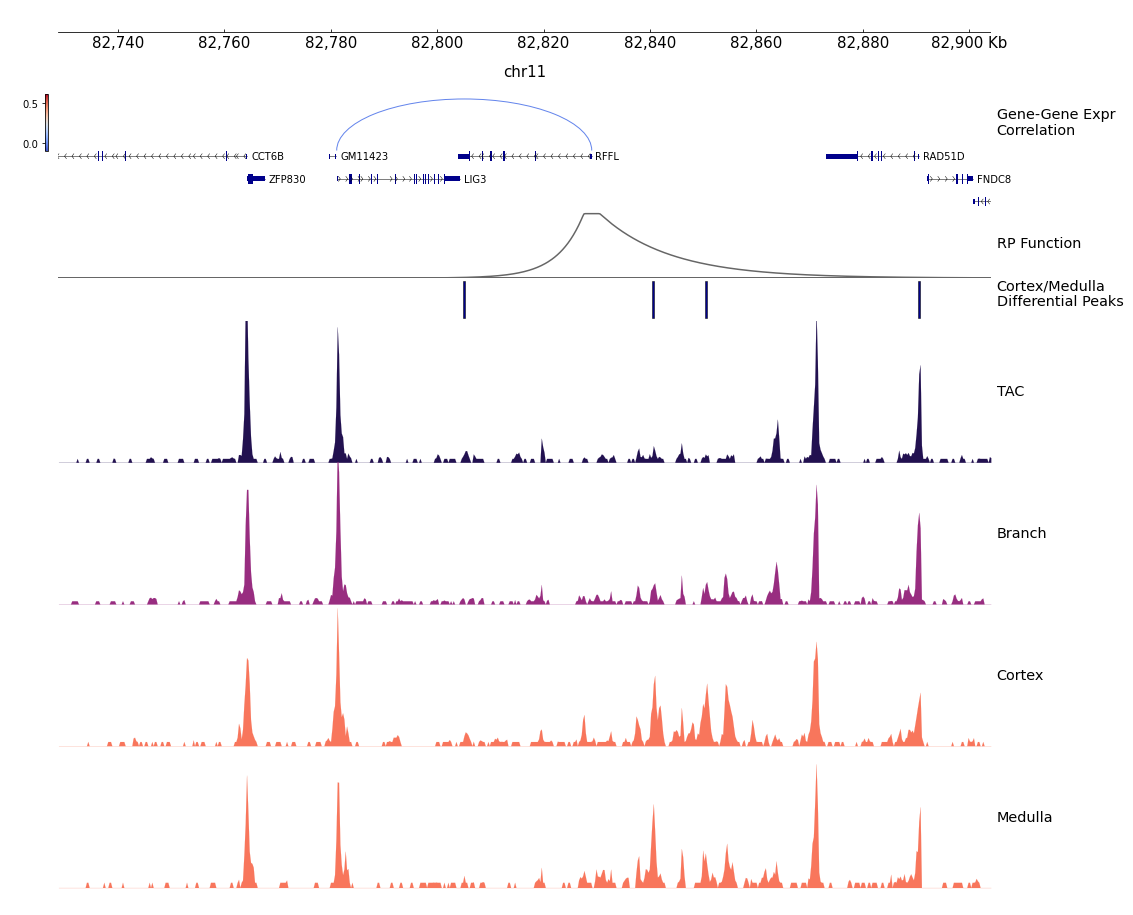

In [33]:
Image('tracks_data/images/_RFFL_chr11-82728818-82904043.png')

# Regulation Graph Making

In [35]:
import pygraphviz as pgv

In [56]:
TAC_NAME = '12 (TAC)\n+RAD50, GCLC'
EIGHT_NAME = '8\n+CCND2, MDC1'
BRANCH_NAME = '15 (Branch)\n+RUNX2, WNT5A, PTCH2'
CORTEX_NAME = '18 (Cortex)\n+WNT3, KCNH1, ATG4B, DSG1'
MEDULLA_NAME = '11 (Medulla)\n+WNT3, COBLL1'
TEN_NAME = '10 (Pre-IRS)\n+KRT71, HSPA1A'
IRS_NAME = '1 (IRS)\n+ACAA2, HADH'

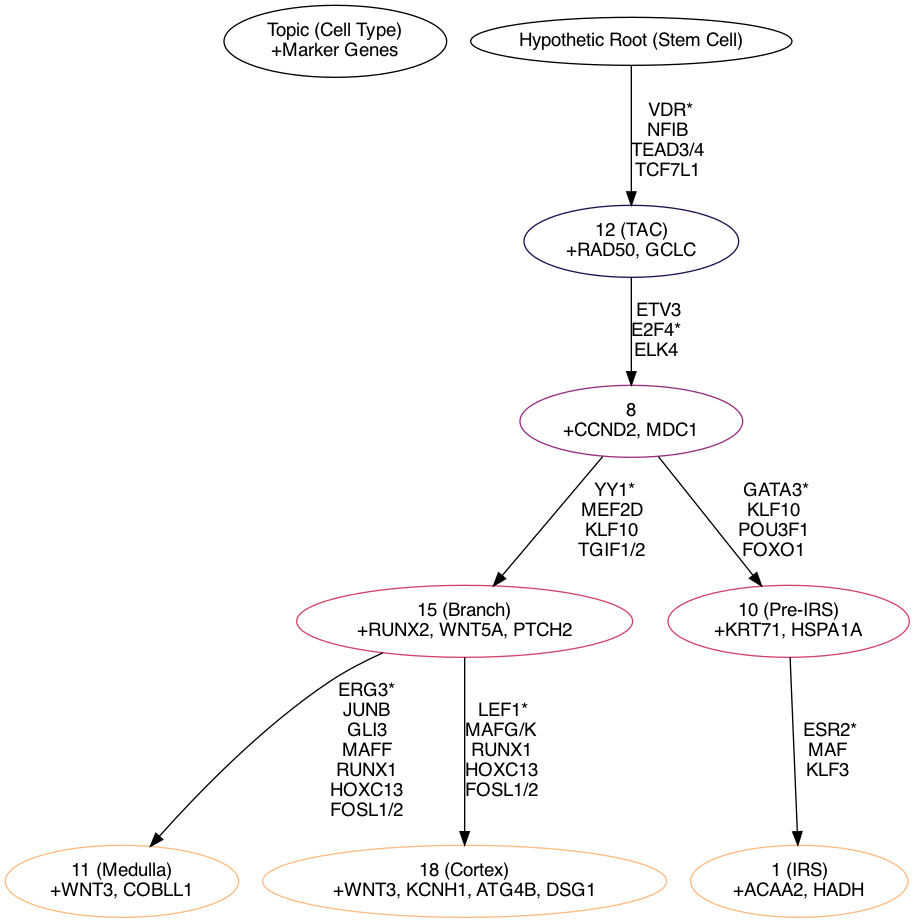

In [57]:
G = pgv.AGraph(strict=False, directed=True, fontname = "helvetica")

G.add_node('Topic (Cell Type)\n+Marker Genes', fontname='helvetica')
G.add_node('Hypothetic Root (Stem Cell)', color = 'black',fontname = "helvetica")
G.add_node(TAC_NAME, color = '#221150',fontname = "helvetica")
G.add_node(EIGHT_NAME, color = '#982d80',fontname = "helvetica")
G.add_node(BRANCH_NAME, color = '#d3436e',fontname = "helvetica")
G.add_node(MEDULLA_NAME, color = '#febb81',fontname = "helvetica")
G.add_node(CORTEX_NAME, color = '#febb81',fontname = "helvetica")
G.add_node(TEN_NAME, color = '#d3436e',fontname = "helvetica")
G.add_node(IRS_NAME, color = '#febb81',fontname = "helvetica")

G.add_edge('Hypothetic Root (Stem Cell)',TAC_NAME, label = ' VDR*\nNFIB\nTEAD3/4\nTCF7L1',fontname = "helvetica")
G.add_edge(TAC_NAME,EIGHT_NAME, label = ' ETV3\nE2F4*\nELK4',fontname = "helvetica")
G.add_edge(EIGHT_NAME,BRANCH_NAME,label = ' YY1*\nMEF2D\nKLF10\nTGIF1/2',fontname = "helvetica")
G.add_edge(BRANCH_NAME,MEDULLA_NAME, label = 'ERG3*           \nJUNB           \nGLI3           \nMAFF           \nRUNX1           \nHOXC13           \nFOSL1/2           ',fontname = "helvetica")
G.add_edge(BRANCH_NAME, CORTEX_NAME, label = ' LEF1*\nMAFG/K\nRUNX1\nHOXC13\nFOSL1/2',fontname = "helvetica")
G.add_edge(EIGHT_NAME,TEN_NAME, label = ' GATA3*\nKLF10\nPOU3F1\nFOXO1',fontname = "helvetica")
G.add_edge(TEN_NAME, IRS_NAME, label = ' ESR2*\nMAF\nKLF3',fontname = "helvetica")

G.layout(prog="dot")  # use dot
G.draw("tracks_data/_reg_graph.png", prog = 'dot')

Image('tracks_data/_reg_graph.png')

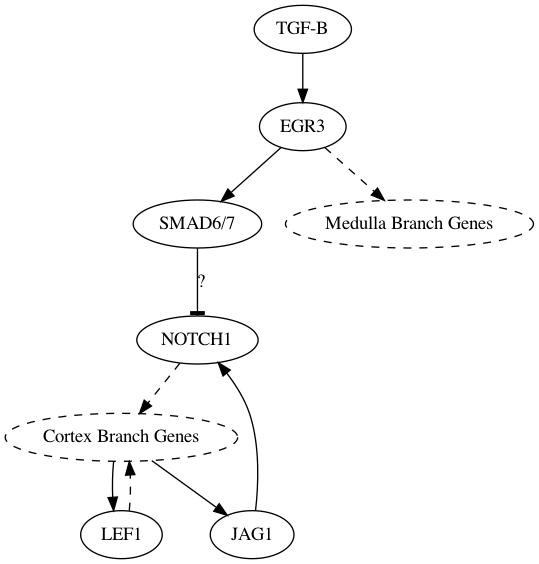

In [65]:
A = pgv.AGraph(strict=False, directed=True, fontname = "helvetica")
A.add_node('TGF-B')
A.add_node('EGR3')
A.add_edge('TGF-B','EGR3')
A.add_node('SMAD6/7')
A.add_edge('EGR3', 'SMAD6/7')

A.add_node('Medulla Branch Genes', style = 'dashed')
A.add_edge('EGR3', 'Medulla Branch Genes', style = 'dashed')

A.add_node('NOTCH1')
A.add_edge('SMAD6/7', 'NOTCH1', arrowhead = 'tee', label = '?')

A.add_node('LEF1')
A.add_node('JAG1')
#A.add_edge('NOTCH1','LEF1', style = 'dashed')
A.add_node('Cortex Branch Genes', style = 'dashed')
A.add_edge('NOTCH1', 'Cortex Branch Genes', style = 'dashed')
A.add_edge('JAG1','NOTCH1')
A.add_edge('Cortex Branch Genes','JAG1')
A.add_edge('Cortex Branch Genes','LEF1')
A.add_edge('LEF1', 'Cortex Branch Genes', style = 'dashed')

A.layout(prog="dot")  # use dot
A.draw("tracks_data/regulation_model.png", prog = 'dot')

Image('tracks_data/regulation_model.png')